## Modules à importer

In [1]:
import math
import scipy
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from sklearn.cluster import KMeans
from variaIa.variaIa import baserate
from variaIa.variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [2]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SDSS', 'SNLS', 'PS1', 'HST', 'SNF']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'SNF')

surv = {'SDSS': d[d['IDSURVEY'] == 1],
        'SNLS': d[d['IDSURVEY'] == 4],
        'PS1':  d[d['IDSURVEY'] == 15],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])],
        'SNF':  d_snf}

colors = {'SDSS': 'lime',
          'SNLS': 'red',
          'PS1': 'blue',
          'HST': 'purple',
          'SNF': 'orange'}

zmax = {'SDSS': 0.22,
        'SNLS': 0.70,
        'PS1': 0.33,
        'HST': 10,
        'SNF': 10}

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()

for survey in surveys[:-1]:
    zmax_cuts[survey] = np.where(surv[survey].zCMB.values < zmax[survey])
    z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
    x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < zmax['SNF'])
z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmax_cuts['SNF']]

datax_all = np.concatenate((np.concatenate((np.concatenate((np.concatenate((x1_zcuts['SNF'],
                                                                            x1_zcuts['SDSS'])),
                                                            x1_zcuts['SNLS'])),
                                            x1_zcuts['PS1'])),
                            x1_zcuts['HST']))

datax_err_all = np.concatenate((np.concatenate((np.concatenate((np.concatenate((x1_err_zcuts['SNF'],
                                                                                x1_err_zcuts['SDSS'])),
                                                                x1_err_zcuts['SNLS'])),
                                                x1_err_zcuts['PS1'])),
                                x1_err_zcuts['HST']))

dataz_all = np.concatenate((np.concatenate((np.concatenate((np.concatenate((z_zcuts['SNF'],
                                                                            z_zcuts['SDSS'])),
                                                            z_zcuts['SNLS'])),
                                            z_zcuts['PS1'])),
                            z_zcuts['HST']))

z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])

z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])

## Fit results for _SNF_

In [3]:
snf_a = 0.477301
snf_mu_1 = 0.386896
snf_sigma_1 = 0.555105
snf_mu_2 = -1.52109
snf_sigma_2 = 0.518584

## Set print level

In [4]:
p_l = ipw.IntSlider(min = 0, max = 1, value = 0, description='print_level:')
display(p_l)

IntSlider(value=0, description='print_level:', max=1)

## EvolSimple

In [5]:
reload(stretchevol)

evol1G = stretchevol.Evol1G1M1S()
evol1G.set_data(dataz_all, datax_all, datax_err_all)

evol1G.minimize(p_l.value)

## EvolKessler

In [118]:
reload(stretchevol)

evol2G1M2S = stretchevol.Evol2G1M2S()
evol2G1M2S.set_data(dataz_all, datax_all, datax_err_all)

evol2G1M2S.minimize(p_l.value,
                    mu = 0.973,
                    sigma_m = 1.5,
                    sigma_p = 0.5)

## EvolHowell

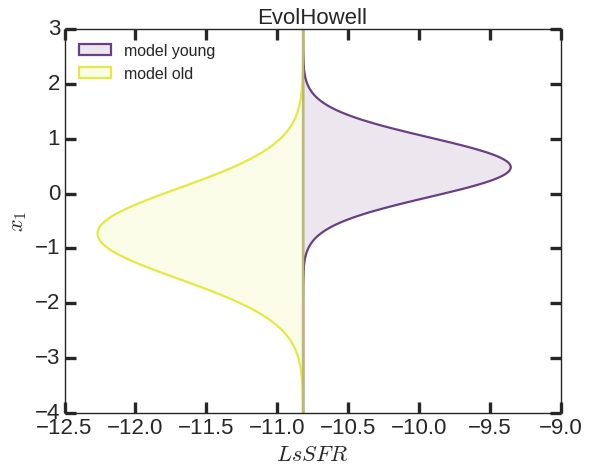

In [133]:
reload(stretchevol)

evol2G2M2S = stretchevol.Evol2G2M2S()
evol2G2M2S.set_data(dataz_all, datax_all, datax_err_all)

evol2G2M2S.minimize(p_l.value, mu_1 = snf_mu_1, sigma_1 = snf_sigma_1,
                               mu_2 = snf_mu_2, sigma_2 = snf_sigma_2)

evol2G2M2S.plotter('EvolHowell')

## EvolHowellFixed

/home/nora/Documents/Thèse/devpython/variaIa/variaIa/stretchevol.py:355: RuntimeWarning: invalid value encountered in log
  evolS.minimize()
/home/nora/installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1663: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/home/nora/installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/home/nora/installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/home/nora/installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1664: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)


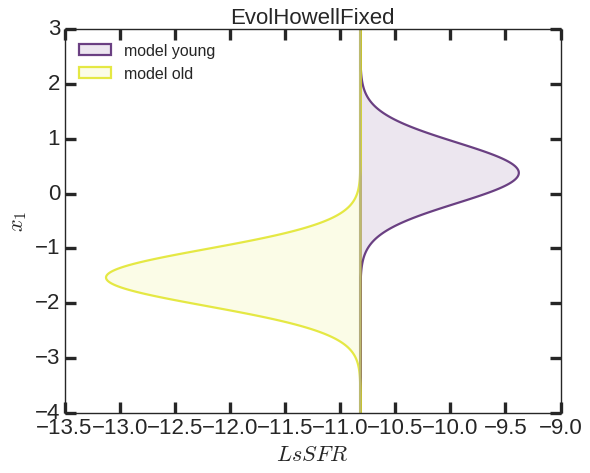

In [105]:
reload(stretchevol)

evol2G2M2SF = stretchevol.Evol2G2M2SF()
evol2G2M2SF.set_data(dataz_all, datax_all, datax_err_all)

evol2G2M2SF.minimize(p_l.value, mu_1 = snf_mu_1, sigma_1 = snf_sigma_1,
                                mu_2 = snf_mu_2, sigma_2 = snf_sigma_2)

evol2G2M2SF.plotter('EvolHowellFixed')

## EvolNR 1S

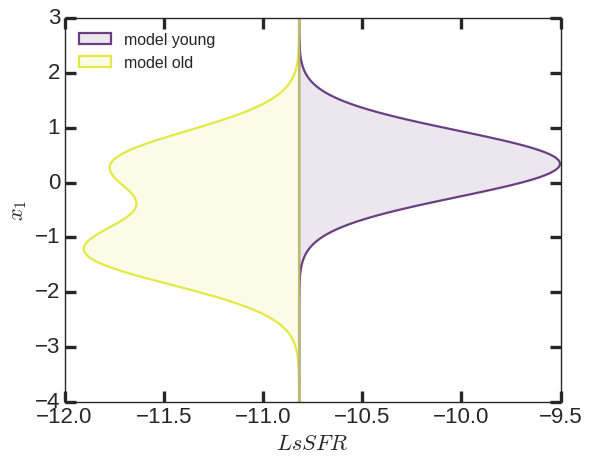

In [134]:
reload(stretchevol)

evol3G2M1S = stretchevol.Evol3G2M1S()
evol3G2M1S.set_data(dataz_all, datax_all, datax_err_all)

evol3G2M1S.minimize(p_l.value, a = snf_a, mu_2 = snf_mu_2,
                               mu_1 = snf_mu_1, sigma_1 = snf_sigma_1)

evol3G2M1S.plotter()

## Utilisation du _mock_ sur large bande de redshifts

In [28]:
evol3G2M1S.param['sigma_2'] = evol3G2M1S.param['sigma_1']

def get_stretch_sample(redshift, npoints, shuffle=True):
    mock = stretchevol.MockEvol()
    mock.set_values(evol3G2M1S.param)
    mock.set_data(redshift, npoints)
    mock.solver()
    mockx = np.concatenate((mock.x1_o,mock.x1_y))
    if shuffle:
        np.random.shuffle(mockx)
    return mockx

In [29]:
zz = np.linspace(0, 2.65, 200)
x1_z = np.asarray([get_stretch_sample(z_, 100000) for z_ in zz])

x_mean = np.mean(x1_z, axis=1)

/home/nora/installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1662: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/nora/installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/home/nora/installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/home/nora/installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1663: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
/home/nora/installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1664: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)


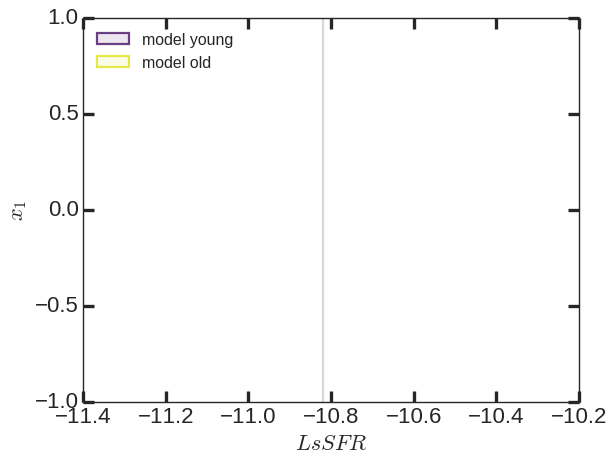

In [136]:
reload(stretchevol)

evolTest = stretchevol.Evol3G2M1S()
evolTest.set_data(zz, x_mean, np.asarray([0 for i in range(len(zz))]))

evolTest.minimize(p_l.value)#, a = snf_a, mu_2 = snf_mu_2,
                            # mu_1 = snf_mu_1, sigma_1 = snf_sigma_1)

evolTest.plotter()

## EvolNR 1S Fixed

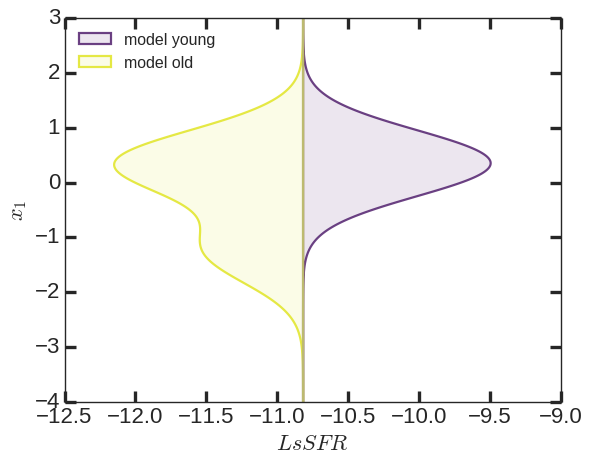

In [137]:
reload(stretchevol)

evol3G2M1SF = stretchevol.Evol3G2M1SF()
evol3G2M1SF.set_data(dataz_all, datax_all, datax_err_all)

evol3G2M1SF.minimize(p_l.value, a = snf_a, mu_2 = snf_mu_2,
                                mu_1 = snf_mu_1, sigma_1 = snf_sigma_1)

evol3G2M1SF.plotter()

## EvolNR 1S SNF

FCN = 350.0876516393866 
 TOTAL NCALL = 69 
 NCALLS = 69 
 
 
 EDM = 4.1898738351174745e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,0.468431,0.0688327,,,,,No
1,mu_1,0.393017,0.0634341,,,,,No
2,sigma_1,0.545565,0.0432614,,,,,No
3,mu_2,-1.5045,0.109125,,,,,No


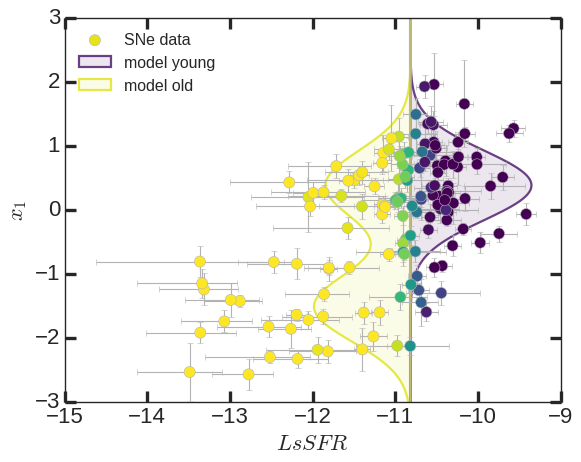

In [148]:
reload(stretchevol)

evol3G2M1SSNF = stretchevol.Evol3G2M1SSNF()
evol3G2M1SSNF.set_lssfr(d_snf['salt2.X1'], d_snf['salt2.X1.err'],
                        d_snf['lssfr'], d_snf['lssfr.err_down'], d_snf['lssfr.err_up'],
                        d_snf['p(prompt)'])

evol3G2M1SSNF.minimize(p_l.value, a = snf_a,
                               mu_1 = snf_mu_1, sigma_1 = snf_sigma_1,
                               mu_2 = snf_mu_2)

evol3G2M1SSNF.plotter()

## EvolNR 2S

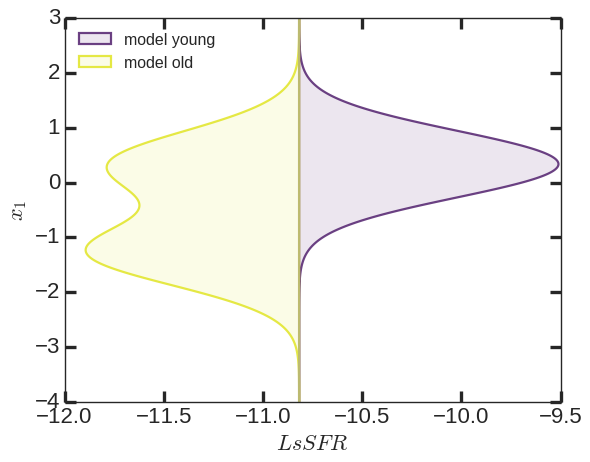

In [138]:
reload(stretchevol)

evol3G2M2S = stretchevol.Evol3G2M2S()
evol3G2M2S.set_data(dataz_all, datax_all, datax_err_all)

evol3G2M2S.minimize(p_l.value, a = snf_a,
                               mu_1 = snf_mu_1, sigma_1 = snf_sigma_1,
                               mu_2 = snf_mu_2, sigma_2 = snf_sigma_2)

evol3G2M2S.plotter()

## EvolNR 2S Fixed

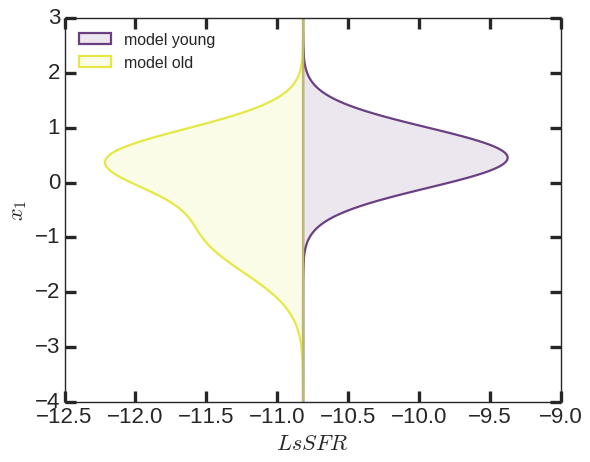

In [139]:
reload(stretchevol)

evol3G2M2SF = stretchevol.Evol3G2M2SF()
evol3G2M2SF.set_data(dataz_all, datax_all, datax_err_all)

evol3G2M2SF.minimize(p_l.value, a = snf_a,
                                mu_1 = snf_mu_1, sigma_1 = snf_sigma_1,
                                mu_2 = snf_mu_2, sigma_2 = snf_sigma_2)

evol3G2M2SF.plotter()

## EvolNR 3G 3M 3S

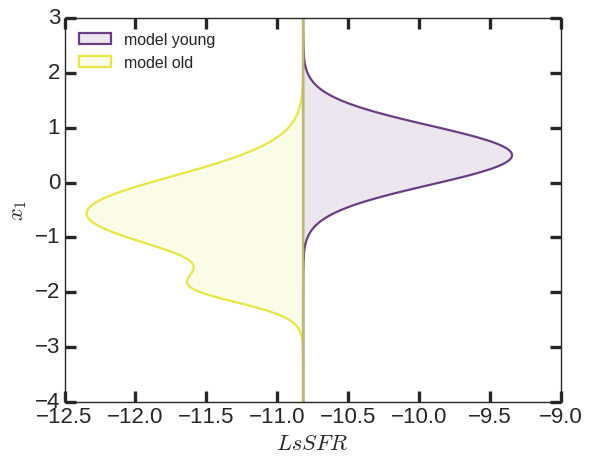

In [142]:
reload(stretchevol)

evol3G3M3S = stretchevol.Evol3G3M3S()
evol3G3M3S.set_data(dataz_all, datax_all, datax_err_all)

evol3G3M3S.minimize(p_l.value, a = snf_a,
                               mu_1 = snf_mu_1, sigma_1 = snf_sigma_1,
                               mu_2 = snf_mu_2, sigma_2 = snf_sigma_2)

evol3G3M3S.plotter()

## Get proba

In [21]:
def get_proba(model):
    return np.exp((evol2G1S.get_aicc() - model.get_aicc())/2)

## Affichage résultats

In [22]:
print('NR 2G1S logL = ', evol2G1S.get_logl())
print('NR 2G1S BIC = ',  evol2G1S.get_bic())
print('NR 2G1S AICc = ', evol2G1S.get_aicc())
print('NR 2G1S prob = ', get_proba(evol2G1S))
print()
print('NR 2G1SF logL = ', evol2G1SF.get_logl())
print('NR 2G1SF BIC = ',  evol2G1SF.get_bic())
print('NR 2G1SF AICc = ', evol2G1SF.get_aicc())
print('NR 2G1SF prob = ', get_proba(evol2G1SF))
print()
print('NR 2G2S logL = ', evol2G2S.get_logl())
print('NR 2G2S BIC = ',  evol2G2S.get_bic())
print('NR 2G2S AICc = ', evol2G2S.get_aicc())
print('NR 2G2S prob = ', get_proba(evol2G2S))
print()
print('NR 2G2SF logL = ', evol2G2SF.get_logl())
print('NR 2G2SF BIC = ',  evol2G2SF.get_bic())
print('NR 2G2SF AICc = ', evol2G2SF.get_aicc())
print('NR 2G2SF prob = ', get_proba(evol2G2SF))
print()
print('Kessler & Scolnic logL = ', evolB.get_logl())
print('Kessler & Scolnic BIC = ',  evolB.get_bic())
print('Kessler & Scolnic AICc = ', evolB.get_aicc())
print('Kessler & Scolnic proba = ',get_proba(evolB))
print()
print('Howell logL = ', evol1G.get_logl())
print('Howell BIC = ',  evol1G.get_bic())
print('Howell AICc = ', evol1G.get_aicc())
print('Howell proba = ',get_proba(evol1G))
print()
print('Normal logL = ', evolS.get_logl())
print('Normal BIC = ',  evolS.get_bic())
print('Normal AICc = ', evolS.get_aicc())
print('Normal proba = ',get_proba(evolS))

NameError: name 'evol2G1S' is not defined